In [1]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

In [2]:
def window_image(img, window_center,window_width, intercept, slope, rescale=True):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    if rescale:
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    return img
    

def get_pixels_hu(image_path, rescale=True): ## Just using hu values
        dicom = pydicom.read_file(image_path)
        image = dicom.pixel_array.astype(np.int16)

    # The intercept is usually -1024, so air is approximately 0
         
    # Convert to Hounsfield units (HU)
        intercept = dicom.RescaleIntercept
        slope = dicom.RescaleSlope
    
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
        
        image += np.int16(intercept)
    
        image[image < -1024] = -1024 # Setting values smaller than air, to air .
        if rescale:
        # Extra rescaling to 0-1
            image = (image - 0) / (max(max(image))- 0)
        return np.array(image, dtype=np.int16)
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)      
    
    
def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def img_crop(img):
    thresholded = cv2.threshold(img.astype('uint8'),0,255,cv2.THRESH_OTSU)
    bbox = cv2.boundingRect(thresholded[1])
    x, y, w, h = bbox
    foreground = img[y:y+h, x:x+w]
    return foreground


def preprocess(dcm):    
    window_center , window_width, intercept, slope = get_windowing(dcm)
    img = dcm.pixel_array
    img = window_image(img, window_center, window_width, intercept, slope)
    img = img_crop(img)
    resized = cv2.resize(img, (224, 224))
    return resized

In [22]:
dcm = pydicom.dcmread('./ID_0002a616e.dcm')

In [78]:
image = preprocess(dcm) #we read the image and store it into variables
imagesharp = preprocess(dcm)
imagefinal = preprocess(dcm)

In [79]:
kernel1 = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]]) #this is our sharp filter

In [80]:
a = np.zeros((image.shape[0],image.shape[1])) #zeros array to store values 
b = np.zeros((image.shape[0],image.shape[1]))

In [81]:
for i in range(1,image.shape[0] - 1): #we apply linear filtering of the kernel across the image, ignoring edges
    for j in range(1,image.shape[1]-1):
        a[i][j] = kernel1[0][0]*image[i-1][j-1] + image[i-1][j]*kernel1[0][1]+ image[i-1][j+1]*kernel1[0][2] + image[i][j-1]*kernel1[1][0] + image[i][j]*kernel1[1][1]+ image[i][j+1]*kernel1[1][2] + image[i+1][j-1]*kernel1[2][0] + image[i+1][j]*kernel1[2][1]+ image[i+1][j+1]*kernel1[2][2]

In [82]:
for i in range(1,imagesharp.shape[0]-1): #we update values on image format
    for j in range(1,imagesharp.shape[1]-1):
        imagesharp[i][j] = a[i][j]

In [83]:
for i in range(1,image.shape[0] - 1): #we store values on array from original image
    for j in range(1,image.shape[1]-1):
        b[i][j] = image[i][j]

In [84]:
for i in range(1,imagefinal.shape[0] - 1): #to update values of pass filter and original image
    for j in range(1,imagefinal.shape[1]-1):
        imagefinal[i][j] = a[i][j] + b[i][j]

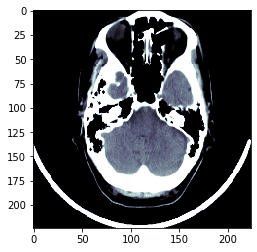

In [85]:
plt.imshow(image, cmap=plt.cm.bone) #original image

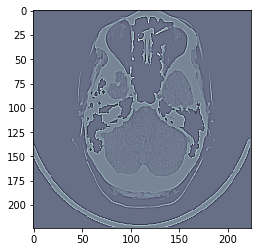

In [86]:
plt.imshow(imagesharp, cmap=plt.cm.bone) #filter

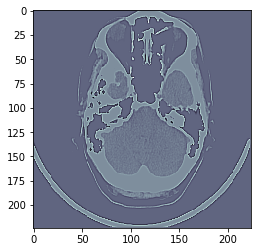

In [87]:
plt.imshow(imagefinal, cmap=plt.cm.bone) #original plus filter

## Problem 2

In [40]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

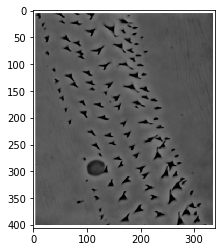

In [41]:
original = mpimg.imread('original.png') #we read original image
plt.imshow(original) 

In [43]:
denticle = Image.open('denticle.png') #we resize template image
new_image = denticle.resize((20,20))
new_image.save('dentsmall.png')

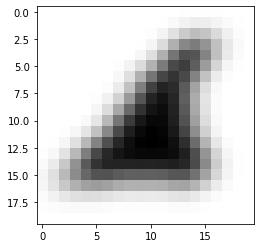

In [44]:
dent = mpimg.imread('dentsmall.png') 
plt.imshow(dent)

In [46]:
G = mpimg.imread('original.png') #we have the original image 

In [47]:
for i in range(original.shape[0]): #we apply cross correlation algorithm 
    for j in range(original.shape[1]):
        g1 = 0
        g2 = 0 
        g3 = 0
        g4 = 0
        for u in range(dent.shape[0]):
            for v in range(dent.shape[1]):
                if (i < original.shape[0] - dent.shape[0]) and (j < original.shape[1] - dent.shape[1]):
                    g1 = g1 + dent[u][v][0]*original[i+u][j+v][0]/(dent.shape[0]*dent.shape[1])
                    g2 = g2 + dent[u][v][1]*original[i+u][j+v][1]/(dent.shape[0]*dent.shape[1])
                    g3 = g3 + dent[u][v][2]*original[i+u][j+v][2]/(dent.shape[0]*dent.shape[1])
                    g4 = g4 + dent[u][v][3]*original[i+u][j+v][3]/(dent.shape[0]*dent.shape[1])
        G[i][j][0] = g1
        G[i][j][1] = g2
        G[i][j][2] = g3
        G[i][j][3] = g4

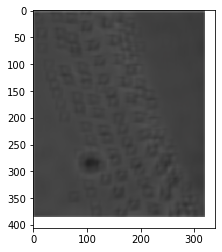

In [48]:
plt.imshow(G)

## Problem 3

In [56]:
image3 = preprocess(dcm)
imageconv3 = preprocess(dcm)
imagefinal3 = preprocess(dcm)

In [57]:
kernel3 = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])

In [58]:
image3.shape

(224, 224)

In [59]:
a3 = np.zeros((image3.shape[0],image3.shape[1]))
b3 = np.zeros((image3.shape[0],image3.shape[1]))

In [60]:
for i in range(1,image3.shape[0] - 1): #we apply convolution with edge detection kernel and do the same as problem 1
    for j in range(1,image3.shape[1]-1):
        a3[i][j]= int(kernel3[0][0]*image3[i+1][j+1] + kernel3[0][1]*image3[j+1][i]+ image3[i+1][j-1]*kernel3[0][2] + image3[i][j+1]*kernel3[1][0] + image3[i][j]*kernel3[1][1]+ image3[i][j-1]*kernel3[1][2] + image3[i-1][j+1]*kernel3[2][0] + image3[i-1][j]*kernel3[2][1]+ image3[i-1][j-1]*kernel3[2][2])

In [62]:
for i in range(1,imageconv3.shape[0]-1):
    for j in range(1,imageconv3.shape[1]-1):
        imageconv3[i][j] = a3[i][j]

In [64]:
for i in range(1,image3.shape[0] - 1):
    for j in range(1,image3.shape[1]-1):
        b3[i][j] = image3[i][j]

In [65]:
for i in range(1,imagefinal3.shape[0] - 1):
    for j in range(1,imagefinal3.shape[1]-1):
        imagefinal3[i][j] = a3[i][j] + b3[i][j]

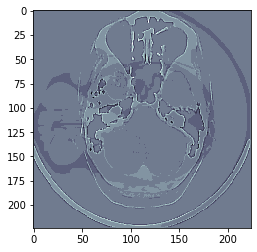

In [66]:
plt.imshow(imageconv3, cmap=plt.cm.bone) #filter

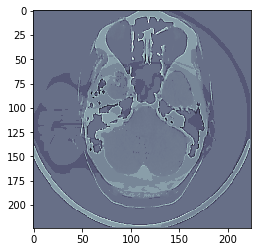

In [67]:
plt.imshow(imagefinal3, cmap=plt.cm.bone) #filter